In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np
import seaborn as sns

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('clean_turnstile_data.csv')

/Users/kendra/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [73]:
df['DATETIME'] = pd.to_datetime(df['DATETIME'], format='%Y-%m-%d %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'])

In [175]:
df.set_index('DATETIME', inplace=True)

In [186]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

Resample dataframe every 4 hours:

In [197]:
df2 = df.groupby(['STATION']).resample(rule='4H').sum().reset_index()

In [198]:
df2.drop(['ENTRIES','EXITS'], axis=1, inplace=True)

Add Day Of Week of column

In [202]:
df2['DAY_OF_WEEK'] = df2['DATETIME'].dt.weekday

In [306]:
df2.head()

,STATION,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,DAY_OF_WEEK
0,1 AV,2018-05-19 00:00:00,1687.0,1107.0,5
1,1 AV,2018-05-19 04:00:00,673.0,1041.0,5
2,1 AV,2018-05-19 08:00:00,2864.0,3578.0,5
3,1 AV,2018-05-19 12:00:00,4839.0,5416.0,5
4,1 AV,2018-05-19 16:00:00,4982.0,6319.0,5


In [220]:
df3 = df2.copy()

In [296]:
df3['DATE'] = pd.to_datetime(df3['DATETIME'].dt.date)
df3['TIME'] = df3['DATETIME'].dt.time

In [303]:
df3['TOTAL'] = df3['ENTRY_DIFFS'] + df3['EXIT_DIFFS']

In [304]:
df3.head()

,STATION,DATETIME,ENTRY_DIFFS,EXIT_DIFFS,DAY_OF_WEEK,DATE,TIME,TOTAL
0,1 AV,2018-05-19 00:00:00,1687.0,1107.0,5,2018-05-19,00:00:00,2794.0
1,1 AV,2018-05-19 04:00:00,673.0,1041.0,5,2018-05-19,04:00:00,1714.0
2,1 AV,2018-05-19 08:00:00,2864.0,3578.0,5,2018-05-19,08:00:00,6442.0
3,1 AV,2018-05-19 12:00:00,4839.0,5416.0,5,2018-05-19,12:00:00,10255.0
4,1 AV,2018-05-19 16:00:00,4982.0,6319.0,5,2018-05-19,16:00:00,11301.0


In [305]:
df3.to_csv('resampled_turnstile_data.csv')

### Sum over all data

to get a list of high-volume stations

In [217]:
grp2 = df2.groupby(['STATION'])['ENTRY_DIFFS','EXIT_DIFFS'].sum().reset_index()

In [230]:
grp2.head()

,STATION,ENTRY_DIFFS,EXIT_DIFFS
0,1 AV,571582.0,624905.0
1,103 ST,804844.0,543799.0
2,103 ST-CORONA,503029.0,365677.0
3,104 ST,71630.0,32287.0
4,110 ST,278100.0,232013.0


In [231]:
exit_high = list(grp2.sort_values('EXIT_DIFFS').tail(15)['STATION'])
entry_high = list(grp2.sort_values('ENTRY_DIFFS').tail(15)['STATION'])
highest_vol = set(exit_high + entry_high)

In [232]:
len(highest_vol)

16

In [233]:
highest_vol

{'125 ST',
 '14 ST-UNION SQ',
 '23 ST',
 '34 ST-HERALD SQ',
 '34 ST-PENN STA',
 '42 ST-PORT AUTH',
 '47-50 STS ROCK',
 '59 ST',
 '59 ST COLUMBUS',
 '86 ST',
 '96 ST',
 'CANAL ST',
 'FLUSHING-MAIN',
 'FULTON ST',
 'GRD CNTRL-42 ST',
 'TIMES SQ-42 ST'}

### Sum by Date

To make sure there are no anomalies on a certain day

In [259]:
grp3 = df3.groupby(['STATION','DATE'])['ENTRY_DIFFS','EXIT_DIFFS'].sum().reset_index()

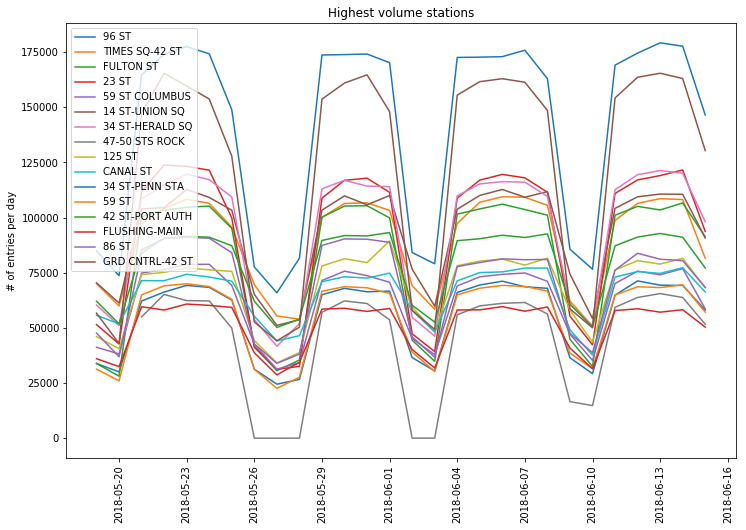

In [260]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp3[grp3['STATION'] == s]
    xs = dum_df['DATE']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['ENTRY_DIFFS'], label=s)
#     xticklocs = ax.get_xticks()
#     plt.xticks(xticklocs, x_labels)
    plt.xticks(rotation=90)
    plt.legend()
    plt.ylabel('# of entries per day')
    plt.title('Highest volume stations');

### Average by Day of week

In [215]:
grp1 = df2.groupby(['STATION', 'DAY_OF_WEEK'])['ENTRY_DIFFS','EXIT_DIFFS'].mean().reset_index()

In [216]:
grp1.head()

,STATION,DAY_OF_WEEK,ENTRY_DIFFS,EXIT_DIFFS
0,1 AV,0,3232.125000,3538.833333
1,1 AV,1,3656.083333,4020.000000
2,1 AV,2,3868.250000,4135.458333
3,1 AV,3,3845.500000,4150.708333
4,1 AV,4,3930.260870,4244.608696


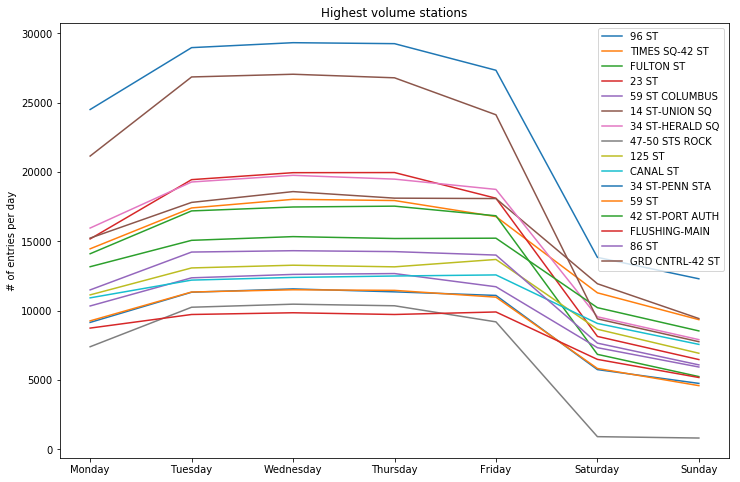

In [236]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION'] == s]
    xs = dum_df['DAY_OF_WEEK']
#     week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['ENTRY_DIFFS'], label=s)

# xticklocs = ax.get_xticks()
plt.xticks(np.arange(7), x_labels)
# plt.xticks(rotation=90)
plt.legend()
plt.ylabel('# of entries per day')
plt.title('Highest volume stations');

### Heatmap: volume of traffic by day of week & time of day, for a given station

# ** Work in Progress below here **

In [261]:
def heatmap_data_by_day(s, data_col, year, month, day):
    '''Given:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        date: year, month, day
    Returns 
        Dataframe summed over that date, for that station, from that data_col'''
    d = dt.datetime(year, month, day)
    dum_df = df3[(df3['DATE'] == d) & (df3['STATION'] == s)]
#     return dum_df.groupby('DATETIME')[data_col].sum()
    return dum_df.groupby('DATETIME')[data_col].sum()

In [313]:
def heatmap_data_by_dow(s, data_col, dow):
    '''Given:
        station key s 
        data_col (e.g. 'ENTRY_DIFFS')
        dow (0-6, with 0 being Monday)
    Returns 
        Dataframe summed over that date, for that station, from that data_col'''
#     d = dt.datetime(year, month, day)
    dum_df = df3[(df3['DAY_OF_WEEK'] == dow) & (df3['STATION'] == s)]
#     return dum_df.groupby('DATETIME')[data_col].sum()
    return dum_df.groupby('TIME')[data_col].sum()

In [310]:
# index 1 = a station that doesn't have neat 0, 4, 8, 12:00 timepoints for 5/19/18
# same with index 2
test_key = list(highest_vol)[0:1][0]
test_key

'96 ST'

In [312]:
s = test_key
dow = 2
dum_df = df3[(df3['DAY_OF_WEEK'] == dow) & (df3['STATION'] == s)]
dum_df.groupby('TIME')['TOTAL'].sum()

TIME
00:00:00      3939.0
04:00:00     93563.0
08:00:00     99619.0
12:00:00    113585.0
16:00:00    136143.0
20:00:00     42381.0
Name: TOTAL, dtype: float64

In [314]:
heatmap_data_by_dow(s, 'ENTRY_DIFFS', 2)

TIME
00:00:00     1643.0
04:00:00    55972.0
08:00:00    62817.0
12:00:00    66920.0
16:00:00    71187.0
20:00:00    19160.0
Name: ENTRY_DIFFS, dtype: float64

In [363]:
hm_data = [heatmap_data_by_day(s, 'ENTRY_DIFFS', 2018, 5, d) for d in range(19,26)]

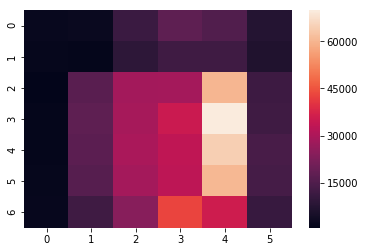

In [366]:
sns.heatmap(hm_data)
plt.xlabels=xticks

In [365]:
xticks

['0h', '4h', '8h', '12h', '16h', '20h']

Average By Day of Week:

In [315]:
hm_data = [heatmap_data_by_dow(s, 'ENTRY_DIFFS', d) for d in range(7)]

In [333]:
hm_data2 = [heatmap_data_by_dow(s, 'EXIT_DIFFS', d) for d in range(7)]

In [334]:
hm_data3 = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]

In [ ]:
xticks = [str(int(x)) + 'h' for x in np.linspace(0,20,6)]
yticks = calendar.day_name[:]

Text(0.5,1,'Total')

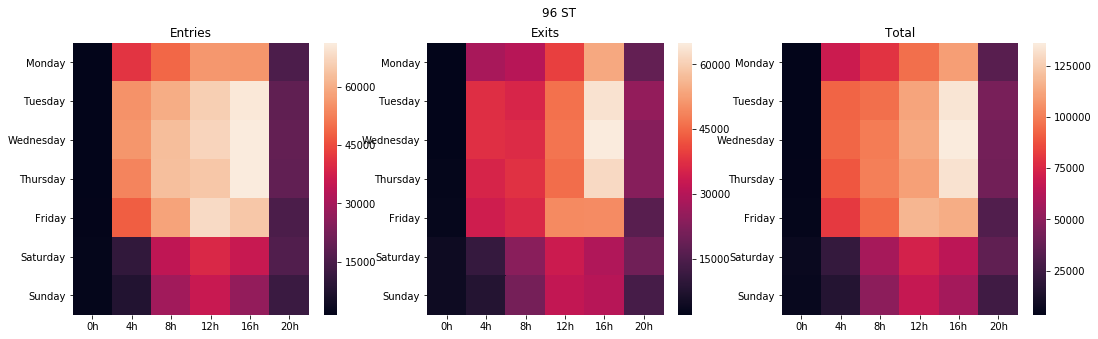

In [339]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
plt.suptitle(s)

plt.subplot(1,3,1)
sns.heatmap(hm_data, xticklabels = xticks, yticklabels=yticks)
plt.title('Entries')

plt.subplot(1,3,2)
sns.heatmap(hm_data2, xticklabels = xticks, yticklabels=yticks)
plt.title('Exits')

plt.subplot(1,3,3)
sns.heatmap(hm_data3, xticklabels = xticks, yticklabels=yticks)
plt.title('Total')

[]

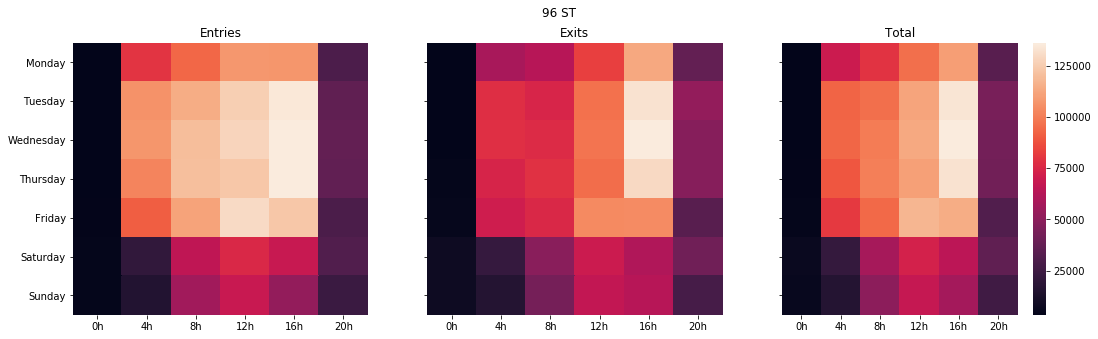

In [344]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
plt.suptitle(s)

ax1 = plt.subplot(1,3,1)
# plt.subplot(1,3,1)
sns.heatmap(hm_data, xticklabels = xticks, yticklabels=yticks, cbar=False)
plt.title('Entries')

ax2 = plt.subplot(1,3,2)
# plt.subplot(1,3,2)
sns.heatmap(hm_data2, xticklabels = xticks, yticklabels=yticks, cbar=False)
plt.title('Exits')
ax2.axes.get_yaxis().set_ticklabels([])

ax3 = plt.subplot(1,3,3)
sns.heatmap(hm_data3, xticklabels = xticks, yticklabels=yticks)
plt.title('Total')
ax3.axes.get_yaxis().set_ticklabels([])

Use total. Make a heatmap for each station in highest_vol list.

In [351]:
highest_vol = list(highest_vol);

In [353]:
len(highest_vol)

16

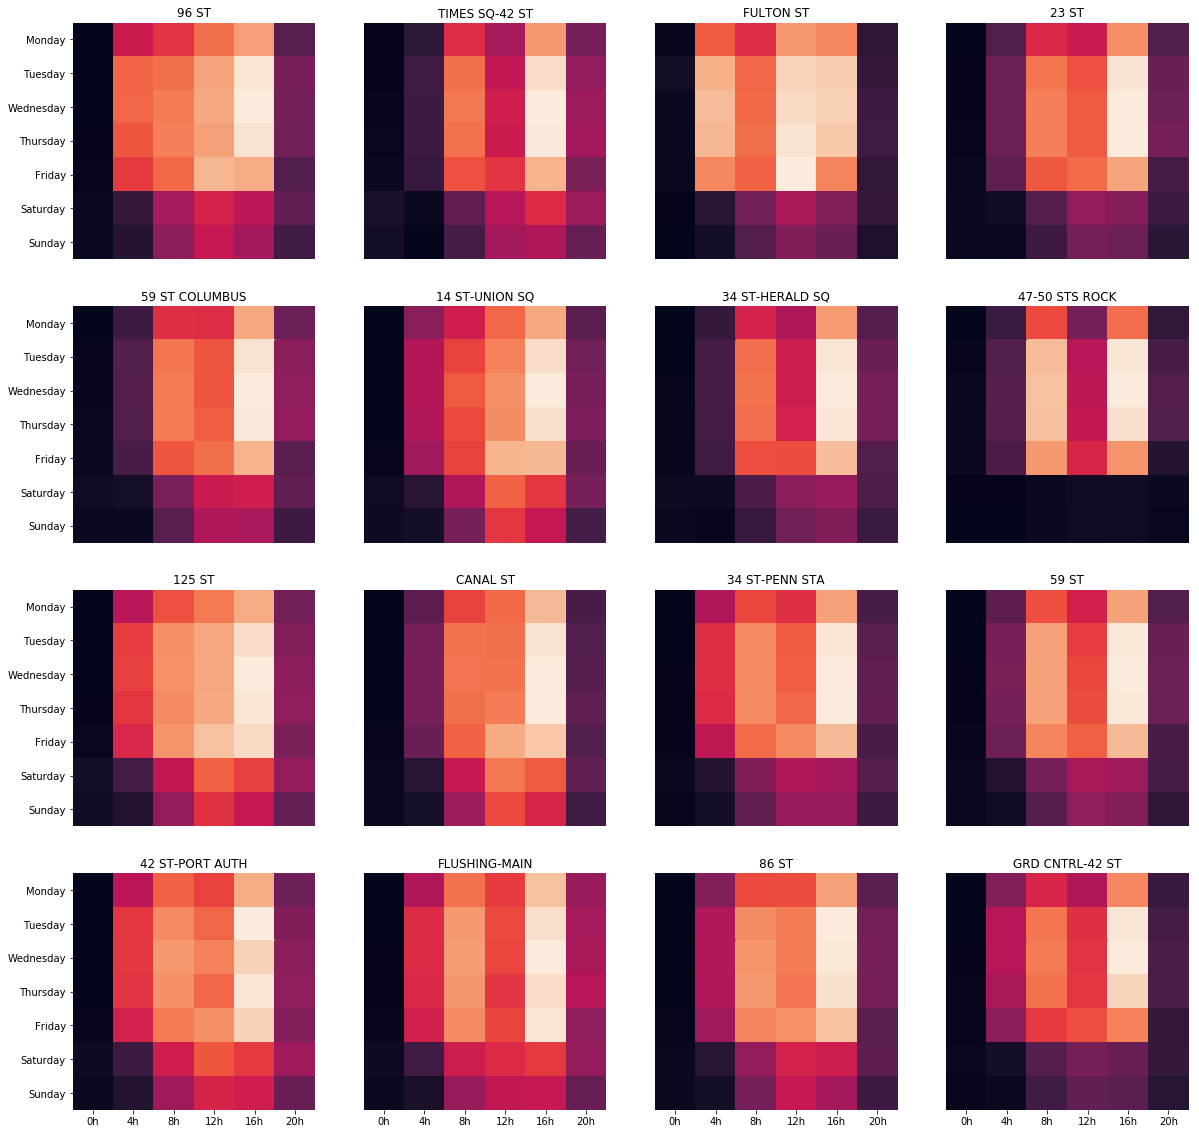

In [369]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

for i, s in enumerate(highest_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=yticks
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xticks
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, cbar=False)
#     sns.heatmap(hm_data, cbar=False)
    plt.title(s)
    



In [370]:
highest_vol

['96 ST',
 'TIMES SQ-42 ST',
 'FULTON ST',
 '23 ST',
 '59 ST COLUMBUS',
 '14 ST-UNION SQ',
 '34 ST-HERALD SQ',
 '47-50 STS ROCK',
 '125 ST',
 'CANAL ST',
 '34 ST-PENN STA',
 '59 ST',
 '42 ST-PORT AUTH',
 'FLUSHING-MAIN',
 '86 ST',
 'GRD CNTRL-42 ST']

In [383]:
lowest_vol = set(list(df3.sort_values('TOTAL').head(130)['STATION']))
len(lowest_vol)

16

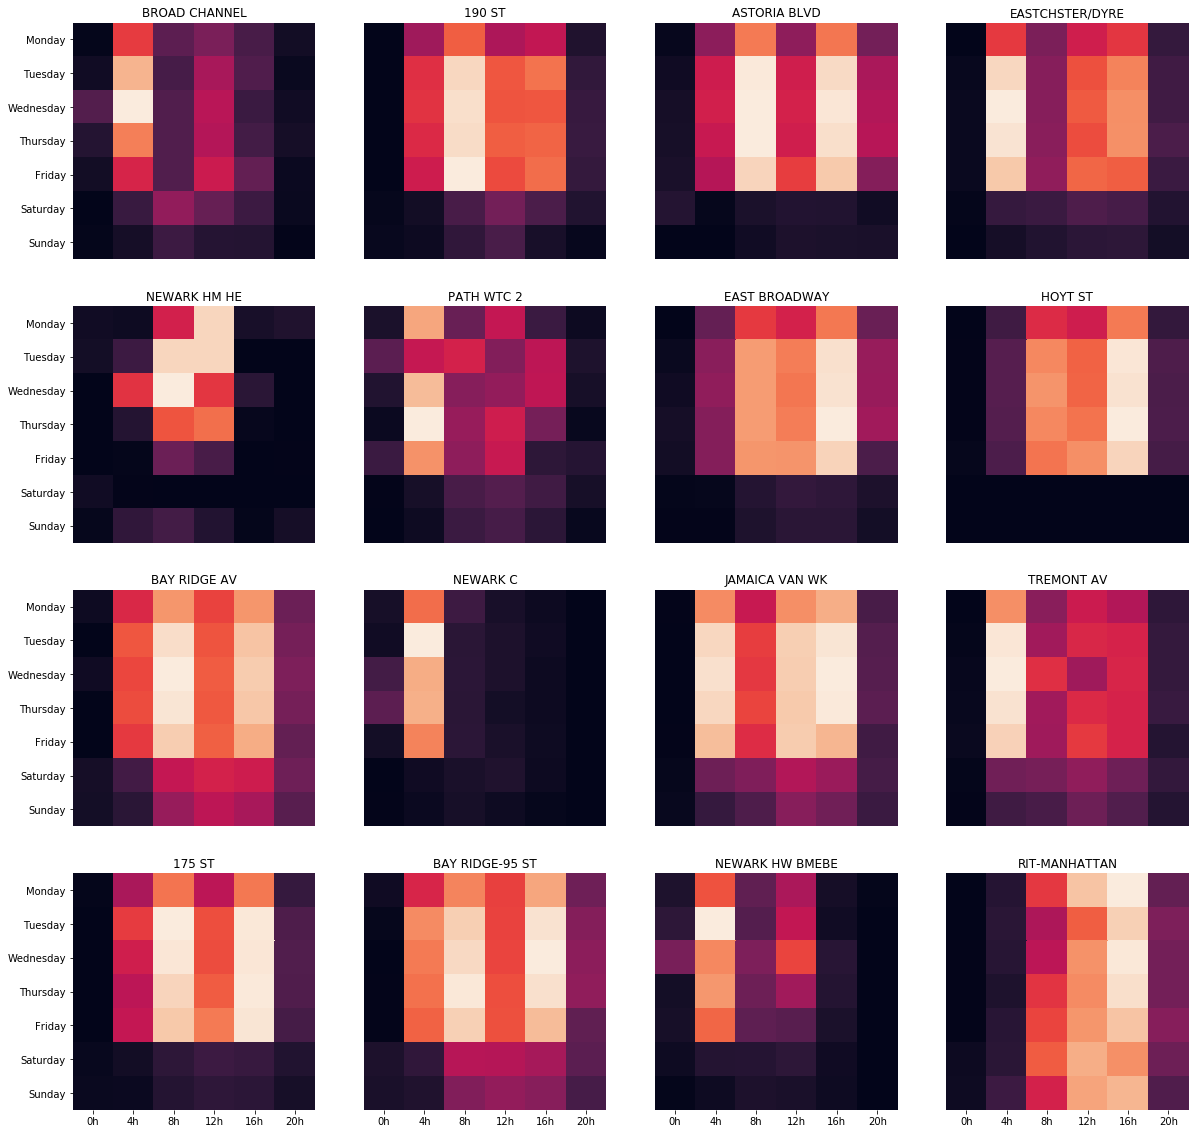

In [384]:
fig, ax = plt.subplots(4,4, figsize=(20,20))

for i, s in enumerate(lowest_vol):
    plt.subplot(4,4,i+1)
    
    if i % 4 == 0:
        ylabel=yticks
    else:
        ylabel=False
    
    if i > 11:
        xlabel=xticks
    else:
        xlabel=False
    
    hm_data = [heatmap_data_by_dow(s, 'TOTAL', d) for d in range(7)]
    sns.heatmap(hm_data, xticklabels = xlabel, yticklabels=ylabel, cbar=False)
#     sns.heatmap(hm_data, cbar=False)
    plt.title(s)
    